<h2>Delta hedging backtester</h2>
This notebook demonstrates a discrete delta-hedging backtester. A delta-hedger is a popular tool for investment banks or others interested in being market neutral. The primary goal is hedging risk. 

In [66]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt


# standard Black-scholes pricing
def bs_price(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S*norm.cdf(d1) - K * np.exp(- r * T) * norm.cdf(d2)

# The delta behind the delta-hedging
def bs_delta(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def pnl_stats(pnl):
    arr = np.asarray(pnl).ravel()
    import pandas as pd
    s = pd.Series(arr)
    return {
        "total_pnl": s.sum(),
        "mean_pnl":  s.mean(),
        "std_pnl":   s.std(ddof = 1),
        "skew_pnl":  s.skew(),
        "kurtosis":  s.kurtosis()
    }

# compute the Sharpe ratio, a metric for measure of performance
def sharpe(pnl, freq):
    return (np.mean(pnl) / np.std(pnl, ddof = 1)) * np.sqrt(freq)

# largest peak to trough
def max_drawdown(cum):
    return np.max(np.maximum.accumulate(cum) - cum)

class DeltaHedger:
    def __init__(self, S, K, r, sigma, T, tc):
        self.S = S
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.tc = tc
        self.delta = None

    def run(self):
        # Flatten inputs
        S = np.asarray(self.S).ravel()
        sig = np.asarray(self.sigma).ravel()
        Tt = np.asarray(self.T).ravel()
        
        N = len(S)
        dt = Tt[0] / N  # daily step
        # compute model prices and deltas
        C = np.array([bs_price(s, self.K, self.r, σ, Tt[i]) for i, (s, σ) in enumerate(zip(S, sig))])
        D = np.array([bs_delta(s, self.K, self.r, σ, Tt[i]) for i, (s, σ) in enumerate(zip(S, sig))])
        self.delta = D
        
        # initial cash: collect model premium C[0], buy D[0] shares
        cash = C[0] - D[0]*S[0]
        shares = D[0]
        pnl = []
        
        for i in range(1, N):
            portfolio_value_start = cash + shares * S[i-1]
            
            # financing cash at risk-free rate
            cash *= np.exp(self.r * dt)
            
            # rebalancing
            dD = D[i] - shares
            cost = self.tc * S[i] * abs(dD)
            cash -= dD * S[i] + cost
            shares = D[i]

            portfolio_value_end = cash + shares * S[i]
            daily_pnl = portfolio_value_end - portfolio_value_start
            
            # mark-to-market
            pnl.append(daily_pnl)
        
        # final payoff at expiry
        hedged_portfolio_value = cash + shares * S[-1]
        option_payoff = max(S[-1] - self.K, 0)
        
        # The final PnL is the difference between the final portfolio value and the option payoff
        final_pnl = hedged_portfolio_value - option_payoff
        pnl[-1] = final_pnl
        
        return np.array(pnl)

symbol = "GOOGL" # Underlying ticker
start = "2023-01-01" # Price data start date
end = "2025-07-30" # Price data end date
expiry = "2025-12-19"  # Option expiry date to hedge to
r = 0.04 # Risk-free rate (annual, continuous)
tc_rate = 0.005 # Transaction cost per share traded (a guess based on some figures I saw)
vol_window = 63 # lookback window (in trading days) for historical vol. 




<h2>1. Load data</h2>

In [67]:
# Project parameters
opts = yf.download(symbol, start=start, end=end)

# Adj Close adjusts for dividends and splits
col = "Adj Close" if "Adj Close" in opts.columns else "Close"
price_series = opts[col].resample("1D").ffill().dropna()
prices = price_series.to_numpy().ravel()

dates = price_series.index.to_pydatetime()

[*********************100%***********************]  1 of 1 completed


<h2>2. Compute Volatility and Time-to-Expiry</h2>

In [68]:
# rolling window of log returns
returns = pd.Series(prices).pct_change().apply(lambda x: np.log(1 + x))
hist_vol = returns.rolling(vol_window, min_periods = 1).std(ddof = 0) * np.sqrt(252)
sigma_series = hist_vol.to_numpy()
# Fill any initial NaNs with first valid vol
sigma_series[:vol_window] = sigma_series[vol_window]

# Time to expiry
expiry_dt = pd.to_datetime(expiry)
T_series = np.array([(expiry_dt - pd.Timestamp(d)).days / 365.0 for d in dates])

# remove dates beyond expiry
mask = T_series > 0
prices = prices[mask]
dates = np.array(dates)[mask]
sigma_series = sigma_series[mask]
T_series = T_series[mask]

<h2> 3. Run Delta Hedging Backtest</h2>

In [69]:
K = prices[0]

hedger = DeltaHedger(prices, K, r, sigma_series, T_series, tc_rate)
pnl = hedger.run().ravel()
cum_pnl = np.cumsum(pnl)


<h2>4. Performance metrics</h2>

A Sharpe ratio above 1 is considered acceptable. For the total PnL, we are hoping that it turns positive at least.

In [70]:
metrics = pnl_stats(pnl)
print("Backtest Metrics")
for k,v in metrics.items():
    print(f"{k:12s}: {v:.4f}")

print(f"Sharpe Ratio : {sharpe(pnl,252):.2f}")

Backtest Metrics
total_pnl   : 84.5846
mean_pnl    : 0.0902
std_pnl     : 2.2817
skew_pnl    : -0.3533
kurtosis    : 9.5411
Sharpe Ratio : 0.63


<h2>5. Plot P&L and cumumlative P&L</h2>

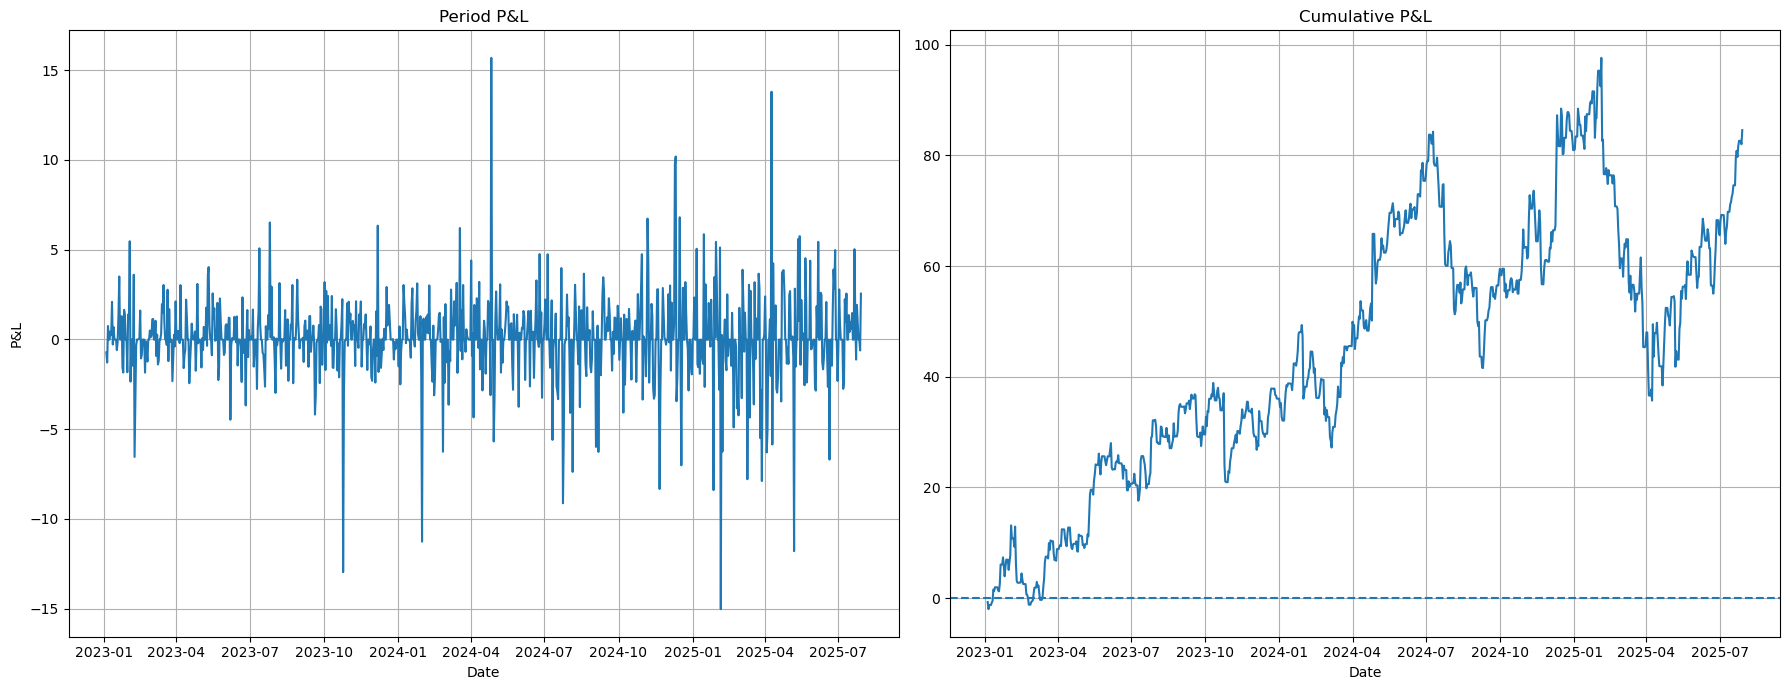

<Figure size 640x480 with 0 Axes>

In [74]:
fig, ax = plt.subplots(1,2, figsize=(18,7))
ax[0].plot(dates[1:], pnl, label="Period P&L"); 
ax[0].set_title("Period P&L"); ax[0].set_xlabel("Date"); ax[0].set_ylabel("P&L"); ax[0].grid()
ax[1].plot(dates[1:], cum_pnl, label = "Cumulative P&L"); ax[1].axhline(0, ls = "--")
ax[1].set_title("Cumulative P&L"); ax[1].set_xlabel("Date"); ax[1].grid()
plt.tight_layout(); plt.show()